# Global Parameter Optimisation

This notebook demonstrates how to optimize parameters in state space models using external optimization packages, such as [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl/) and [Flux.jl](https://github.com/FluxML/Flux.jl). We utilize **RxInfer.jl**, a powerful package for inference in probabilistic models.

By the end of this notebook, you will have practical knowledge of global parameter optimization in state space models. You will learn how to optimize parameters in both univariate and multivariate state space models, and harness the power of external optimization packages such as **Optim.jl** and **Flux.jl**.

## Univariate State Space Model

Let us try use the following simple state space model:

$$\begin{aligned}
    {x}_t &= {x}_{t-1} + c \\
    {y}_t &\sim \mathcal{N}\left({x}_{t}, p \right) 
\end{aligned}$$

with prior ${x}_0 \sim \mathcal{N}({m_{{x}_0}}, {v_{{x}_0}})$. Our goal is to optimize parameters $c$ and ${m_{{x}_0}}$.

In [1]:
using RxInfer, BenchmarkTools, Random, LinearAlgebra, Plots

In [2]:
@model function smoothing(y, x0, c, P)
    
    x_prior ~ Normal(mean = mean(x0), var = var(x0)) 
    x_prev = x_prior

    for i in eachindex(y)
        x[i] ~ x_prev + c
        y[i] ~ Normal(mean = x[i], var = P)
        x_prev = x[i]
    end
end

In [3]:
rng = MersenneTwister(42)

P      = 1.0
n      = 250
c_real = -5.0
data   = c_real .+ collect(1:n) + rand(rng, Normal(0.0, sqrt(P)), n);

In [4]:
# c[1] is C
# c[2] is μ0
function f(c)
    x0_prior = NormalMeanVariance(c[2], 100.0)
    result = infer(
        model = smoothing(x0 = x0_prior, c = c[1], P = P), 
        data  = (y = data,), 
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

In [5]:
using Optim

In [6]:
res = optimize(f, ones(2), GradientDescent(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     3.792822e+02     1.799567e+03
 * time: 0.020724058151245117
    10     3.778754e+02     3.170777e+01
 * time: 5.0720460414886475
    20     3.778738e+02     1.762757e+01
 * time: 9.499404907226562
    30     3.778722e+02     1.433630e+01
 * time: 14.146775007247925


 * Status: success

 * Candidate solution
    Final objective value:     3.778722e+02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 1.10e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.33e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.89e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.09e-07 ≰ 0.0e+00
    |g(x)|                 = 5.06e-04 ≤ 1.0e-03

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    31
    f(x) calls:    224
    ∇f(x) calls:   224


In [7]:
res.minimizer # Real values are indeed (c = 1.0 and μ0 = -5.0)

2-element Vector{Float64}:
  0.9986235925373311
 -4.72238362144187

In [8]:
println("Real value vs Optimized")
println("Real:      ", [ 1.0, c_real ])
println("Optimized: ", res.minimizer)

Real value vs Optimized
Real:      [1.0, -5.0]
Optimized: [0.9986235925373311, -4.72238362144187]


## Multivariate state space model

Let us consider the multivariate state space model:

$$\begin{aligned}
    \mathbf{x}_t &\sim \mathcal{N}\left(\mathbf{Ax}_{t-1}, \mathbf{Q} \right) \\
    \mathbf{y}_t &\sim \mathcal{N}\left(\mathbf{x}_{t}, \mathbf{P} \right) 
\end{aligned}$$

with prior 

$$\begin{aligned}
\mathbf{x}_0 \sim \mathcal{N}(\mathbf{m_{{x}_0}}, \mathbf{V_{{x}_0}})\
\end{aligned}$$ 

and transition matrix 

$$\begin{aligned}
\mathbf{A} = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}
\end{aligned}$$

Covariance matrices $\mathbf{V_{{x}_0}}$, $\mathbf{P}$ and $\mathbf{Q}$ are known. Our goal is to optimize parameters $\mathbf{m_{{x}_0}}$ and $\theta$.

In [9]:
using RxInfer, BenchmarkTools, Random, LinearAlgebra, Plots

In [10]:
@model function rotate_ssm(y, θ, x0, Q, P)
    
    x_prior ~ MvNormal(mean = mean(x0), cov = cov(x0))
    x_prev = x_prior
    
    A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
    
    for i in eachindex(y)
        x[i] ~ MvNormal(mean = A * x_prev, covariance = Q)
        y[i] ~ MvNormal(mean = x[i], covariance = P)
        x_prev = x[i]
    end
    
end

In [11]:
# Generate data
function generate_rotate_ssm_data()
    rng = MersenneTwister(1234)

    θ = π / 8
    A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
    Q = Matrix(Diagonal(1.0 * ones(2)))
    P = Matrix(Diagonal(1.0 * ones(2)))

    n = 300

    x_prev = [ 10.0, -10.0 ]

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        
        x[i] = rand(rng, MvNormal(A * x_prev, Q))
        y[i] = rand(rng, MvNormal(x[i], Q))
        
        x_prev = x[i]
    end

    return θ, A, Q, P, n, x, y
end

generate_rotate_ssm_data (generic function with 1 method)

In [12]:
θ, A, Q, P, n, x, y = generate_rotate_ssm_data();

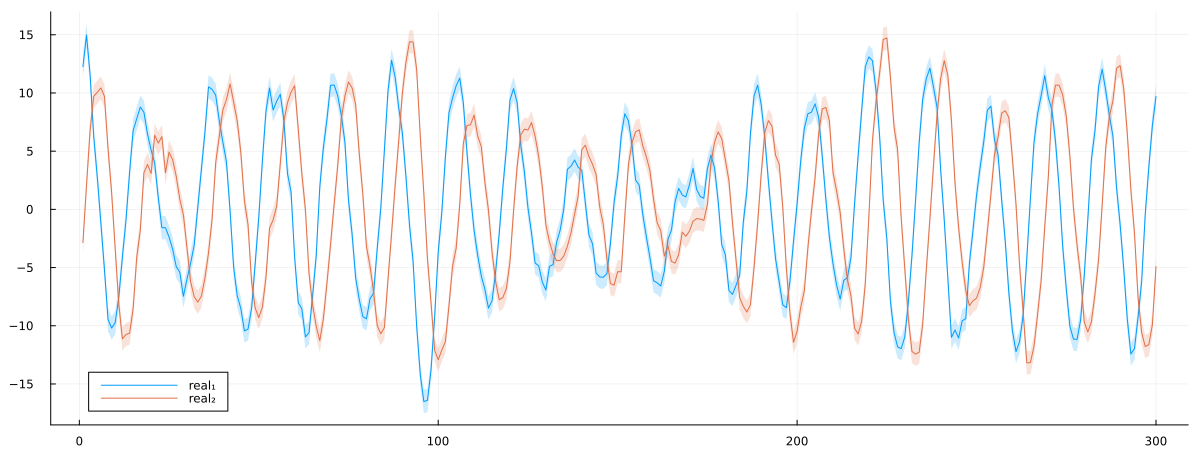

In [13]:
px = plot()

px = plot!(px, getindex.(x, 1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "real₁")
px = plot!(px, getindex.(x, 2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "real₂")

plot(px, size = (1200, 450))

In [14]:
function f(θ)
    x0 = MvNormalMeanCovariance([ θ[2], θ[3] ], Matrix(Diagonal(0.01 * ones(2))))
    result = infer(
        model = rotate_ssm(θ = θ[1], x0 = x0, Q = Q, P = P), 
        data  = (y = y,), 
        free_energy = true
    )
    return result.free_energy[end]
end

f (generic function with 1 method)

In [15]:
res = optimize(f, zeros(3), LBFGS(), Optim.Options(f_tol = 1e-14, g_tol = 1e-12, show_trace = true, show_every = 10))

Iter     Function value   Gradient norm 
     0     2.989629e+03     8.134620e+03
 * time: 8.392333984375e-5
    10     1.151223e+03     8.512631e-10
 * time: 10.613430976867676


 * Status: success

 * Candidate solution
    Final objective value:     1.151223e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.87e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.41e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 1.0e-14
    |g(x)|                 = 8.51e-10 ≰ 1.0e-12

 * Work counters
    Seconds run:   11  (vs limit Inf)
    Iterations:    10
    f(x) calls:    52
    ∇f(x) calls:   52


In [16]:
println("Real value vs Optimized")
println("Real:      ", θ)
println("Optimized: ", res.minimizer[1])

@show sin(θ), sin(res.minimizer[1])
@show cos(θ), cos(res.minimizer[1])

Real value vs Optimized
Real:      0.39269908169872414
Optimized: 132.3277369208505
(sin(θ), sin(res.minimizer[1])) = (0.3826834323650898, 0.3717054949118028)
(cos(θ), cos(res.minimizer[1])) = (0.9238795325112867, 0.9283507015413797)


(0.9238795325112867, 0.9283507015413797)

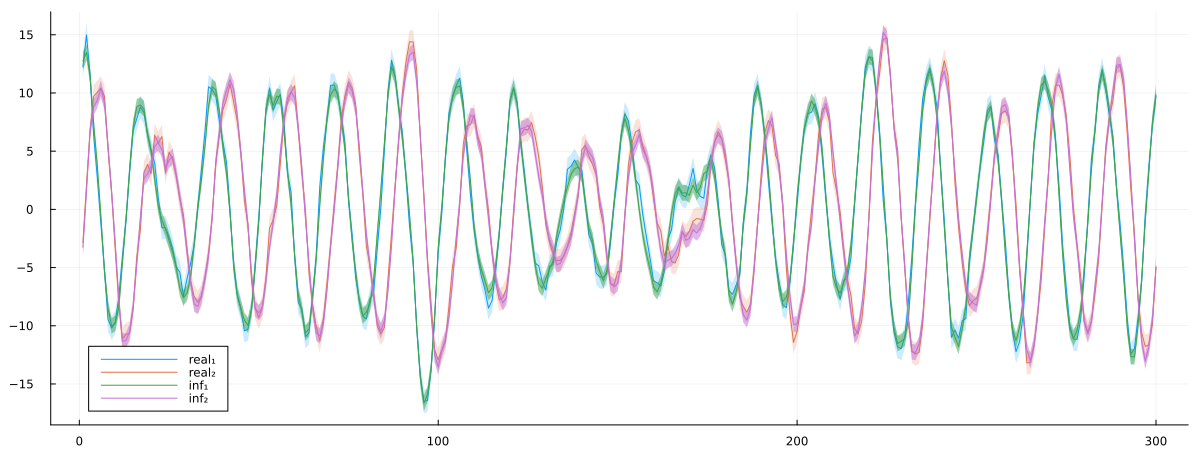

In [17]:
x0 = MvNormalMeanCovariance([ res.minimizer[2], res.minimizer[3] ], Matrix(Diagonal(100.0 * ones(2))))

result = infer(
    model = rotate_ssm(θ = res.minimizer[1], x0 = x0, Q = Q, P = P), 
    data  = (y = y,), 
    free_energy = true
)

xmarginals = result.posteriors[:x]

px = plot()

px = plot!(px, getindex.(x, 1), ribbon = diag(Q)[1] .|> sqrt, fillalpha = 0.2, label = "real₁")
px = plot!(px, getindex.(x, 2), ribbon = diag(Q)[2] .|> sqrt, fillalpha = 0.2, label = "real₂")
px = plot!(px, getindex.(mean.(xmarginals), 1), ribbon = getindex.(var.(xmarginals), 1) .|> sqrt, fillalpha = 0.5, label = "inf₁")
px = plot!(px, getindex.(mean.(xmarginals), 2), ribbon = getindex.(var.(xmarginals), 2) .|> sqrt, fillalpha = 0.5, label = "inf₂")

plot(px, size = (1200, 450))

## Learning Kalman filter with LSTM driven dynamic

In this example, our focus is on Bayesian state estimation in a Nonlinear State-Space Model. Specifically, we will utilize the time series generated by the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) as an example. 

Our objective is to compute the marginal posterior distribution of the latent (hidden) state $x_k$ at each time step $k$, considering the history of measurements up to that time step:

$$p(x_k | y_{1:k}).$$

The above expression represents the probability distribution of the latent state $x_k$ given the measurements $y_{1:k}$ up to time step $k$.

In [18]:
using RxInfer, BenchmarkTools, Flux, ReverseDiff, Random, Plots, LinearAlgebra, ProgressMeter, JLD, StableRNGs

### Generate data

In [19]:
# Lorenz system equations to be used to generate dataset
Base.@kwdef mutable struct Lorenz
    dt::Float64
    σ::Float64
    ρ::Float64
    β::Float64
    x::Float64
    y::Float64
    z::Float64
end

function step!(l::Lorenz)
    dx = l.σ * (l.y - l.x);         l.x += l.dt * dx
    dy = l.x * (l.ρ - l.z) - l.y;   l.y += l.dt * dy
    dz = l.x * l.y - l.β * l.z;     l.z += l.dt * dz
end
;

In [20]:
# Dataset
rng = StableRNG(999)

ordered_dataset = []
ordered_parameters = []
for σ = 11:15
    for ρ = 23:27
        for β_nom = 6:9
            attractor = Lorenz(0.02, σ, ρ, β_nom/3.0, 1, 1, 1)
            noise_free_data = [[1.0, 1.0, 1.0]]
            for i=1:99
                step!(attractor)
                push!(noise_free_data, [attractor.x, attractor.y, attractor.z])
            end
            push!(ordered_dataset, noise_free_data)
            push!(ordered_parameters, [σ, ρ, β_nom/3.0])
        end
    end
end

new_order = collect(1:100)
shuffle!(rng,new_order)

dataset = [] # noisy dataset
noise_free_dataset = [] # noise free dataset
lorenz_parameters = []

for i in new_order
    local data = []
    push!(noise_free_dataset, ordered_dataset[i])
    push!(lorenz_parameters, ordered_parameters[i])
    for nfd in ordered_dataset[i]
        push!(data,nfd+randn(rng,3))
    end
    push!(dataset, data)
end

trainset = dataset[1:60]
validset = dataset[61:80]
testset = dataset[81:end]

noise_free_trainset = noise_free_dataset[1:60]
noise_free_validset = noise_free_dataset[61:80]
noise_free_testset = noise_free_dataset[81:end]
;

### Data visualization

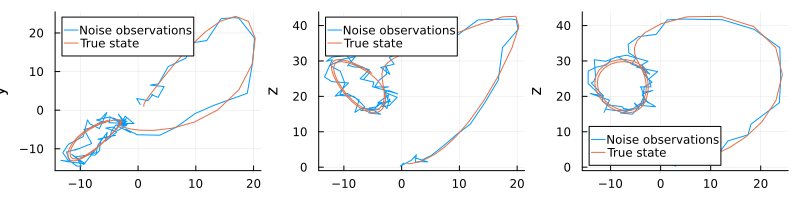

In [21]:
one_nonoise=noise_free_trainset[1]
one=trainset[1]
gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)
for i=1:100
    rx[i], ry[i], rz[i] = one[i][1], one[i][2], one[i][3]
    gx[i], gy[i], gz[i] = one_nonoise[i][1], one_nonoise[i][2], one_nonoise[i][3]
end
p1=plot(rx,ry,label="Noise observations")
p1=plot!(gx,gy,label="True state")
xlabel!("x")
ylabel!("y")
p2=plot(rx,rz,label="Noise observations")
p2=plot!(gx,gz,label="True state")
xlabel!("x")
ylabel!("z")
p3=plot(ry,rz,label="Noise observations")
p3=plot!(gy,gz,label="True state")
xlabel!("y")
ylabel!("z")
plot(p1, p2, p3, size = (800, 200),layout=(1,3))

### Inference

We use the following state-space model representation:

$$\begin{aligned}
x_k \sim p(x_k | x_{k-1}) \\
y_k \sim p(y_k | x_k).
\end{aligned}$$

where $x_k \sim p(x_k | x_{k-1})$ represents the hidden dynamics of our system. 
The hidden dynamics of the Lorenz system exhibit nonlinearities and hence cannot be solved in the closed form.
One manner of solving this problem is by introducing a neural network to approximate the transition matrix of the Lorenz system. 

$$\begin{aligned}
A_{k-1}=NN(y_{k-1}) \\
p(x_k | x_{k-1})=\mathcal{N}(x_k | A_{k-1}x_{k-1}, Q) \\
p(y_k | x_k)=\mathcal{N}(y_k | Bx_k, R)
\end{aligned}$$

where $NN$ is the neural network. The input is the observation $y_{k-1}$, and output is the trasition matrix $A_{k-1}$.
$B$ denote distortion or measurment matrix. $Q$ and $R$ are covariance matrices. Note that the hidden state $x_k$ comprises three coordinates, i.e. $x_k = (rx_k, ry_k, rz_k)$

By employing this state-space model representation and utilizing the neural network approximation, we can estimate the hidden dynamics and perform inference in the Lorenz system.

In [22]:
# Neural Network model
mutable struct NN
    InputLayer
    OutputLater
    g
    params
    function NN(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
        InputLayer = Dense(W1, b1, relu)
        Lstm = LSTM(W2_1,W2_2,b2,s2_1)
        OutputLayer = Dense(W3, b3)
        g = Chain(InputLayer, OutputLayer);
        new(InputLayer, OutputLayer, g, (W1,b1,W2_1,W2_2,b2,s2_1,W3,b3))
    end
end

### Model specification
Note that we treat the trasition matrix $A_{k-1}$ as time-varying.

In [23]:
#State Space Model
@model function ssm(y, As, Q, B, R)
    
    x_prior_mean = zeros(3)
    x_prior_cov  = Matrix(Diagonal(ones(3)))
    
    x[1] ~ MvNormal(mean = x_prior_mean, cov = x_prior_cov)
    y[1] ~ MvNormal(mean = B * x[1], cov = R)
    
    for i in 2:length(y)
        x[i] ~ MvNormal(mean = As[i - 1] * x[i - 1], cov = Q) 
        y[i] ~ MvNormal(mean = B * x[i], cov = R)
    end
end

We set distortion matrix $B$ and the covariance matrices $Q$ and $R$ as identity matrix.

In [24]:
Q = Matrix(Diagonal(ones(3)))*2
B = Matrix(Diagonal(ones(3)))
R = Matrix(Diagonal(ones(3)))
;

We use the *inference* function in the **RxInfer.jl**. Before that, we need to bulid a function to get the matrix $A$ output by the neural network. And the $A$ is treated as a datavar in the inference function.

In [25]:
function get_matrix_AS(data,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    n = length(data)
    neural = NN(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    Flux.reset!(neural)
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), data[1:end-1])
    return As
end

get_matrix_AS (generic function with 1 method)

The weights of neural network $NN$ are initialized as follows:

In [26]:
# Initial model parameters
W1, b1 = randn(5, 3)./100, randn(5)./100
W2_1, W2_2, b2, s2_1, s2_2 = randn(5 * 4, 5) ./ 100, randn(5 * 4, 5) ./ 100, randn(5*4) ./ 100, zeros(5), zeros(5)
W3, b3 = randn(3, 5) ./ 100, randn(3) ./ 100
;

Before network training, we show the inference results for the hidden states:

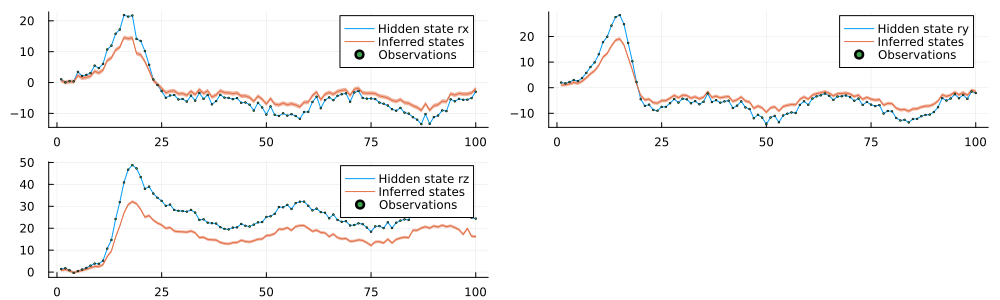

In [27]:
# Performance on an instance from the testset before training
index = 1
data=testset[index]
n=length(data)
result = infer(
    model = ssm(As = get_matrix_AS(data,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3),Q = Q,B = B,R = R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx,label="Hidden state rx")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)
p1 = scatter!(first.(testset[index]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Hidden state ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Hidden state rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index]), label="Observations", markersize=1.0)


plot(p1, p2, p3, size = (1000, 300))

### Training network

In this part, we use the Free Energy as the objective function to optimize the weights of network.

In [28]:
# free energy objective to be optimized during training
function fe_tot_est(W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
    fe_ = 0
    for train_instance in trainset
        result = infer(
            model = ssm(n, get_matrix_AS(train_instance,W1,b1,W2_1,W2_2,b2,s2_1,W3,b3),Q,B,R), 
            data  = (y = train_instance, ), 
            returnvars = (x = KeepLast(), ),
            free_energy = true
        )
        fe_ += result.free_energy[end]
    end
    return fe_
end

fe_tot_est (generic function with 1 method)

# Training

In [29]:
# Training is a computationally expensive procedure, for the sake of an example we load pre-trained weights
# Uncomment the following code to train the network manually
# opt = Flux.Optimise.RMSProp(0.006, 0.95)
# params = (W1,b1,W2_1,W2_2,b2,s2_1,W3,b3)
# @showprogress for epoch in 1:800
#     grads = ReverseDiff.gradient(fe_tot_est, params);
#     for i=1:length(params)
#         Flux.Optimise.update!(opt,params[i],grads[i])
#     end
# end

### Test

Import the weights of neural network that we have trained.

In [30]:
W1a, b1a, W2_1a, W2_2a, b2a, s2_1a, W3, b3a = load("nn_prediction/weights.jld")["data"];

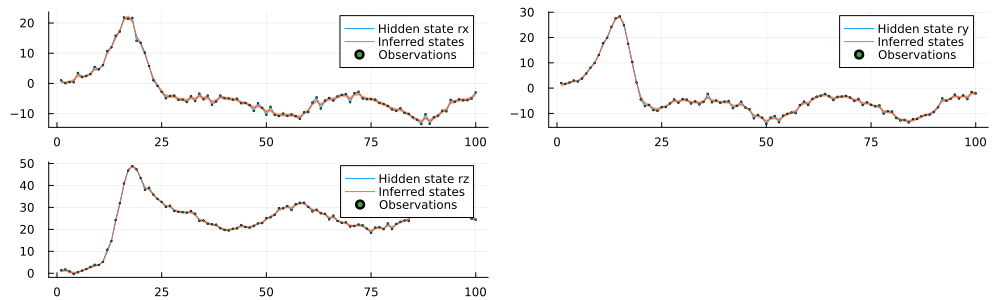

In [31]:
# Performance on an instance from the testset after training
index = 1
data = testset[index]
n = length(data)
result = infer(
    model = ssm(As=get_matrix_AS(data,W1a,b1a,W2_1a,W2_2a,b2a,s2_1a,W3,b3a),Q=Q,B=B,R=R), 
    data  = (y = data, ), 
    returnvars = (x = KeepLast(), ),
    free_energy = true
)
x_est=result.posteriors[:x]

gx, gy, gz = zeros(100), zeros(100), zeros(100)
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)

for i=1:100
    gx[i], gy[i], gz[i] = noise_free_testset[index][i][1], noise_free_testset[index][i][2], noise_free_testset[index][i][3]
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end

p1 = plot(rx,label="Hidden state rx")
p1 = plot!(rx_est_m,label="Inferred states", ribbon=rx_est_var)
p1 = scatter!(first.(testset[index]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Hidden state ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Hidden state rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index]), label="Observations", markersize=1.0)

plot(p1, p2, p3, size = (1000, 300))

### Prediction

In the above instances, the observations during whole time are available. For prediction task, we can only access to the  observations untill $k$ and estimate the future state at time $k+1$, $k+2$, $\dots$,$k+T$.

We can still solve this problem by the trained neural network to approximate the transition matrix. And we can get the one-step prediction in the future. Then, the predicted results are feed into the neural network to generate the transition matrix for the next step, and roll into the future to get the multi-step prediction.

$$\begin{aligned}
A_{k}=NN(x_{k}) \\
p(x_{k+1} | x_{k})=\mathcal{N}(x_{k+1} | A_{k}x_{k}, Q) \\
\end{aligned}$$

In [32]:
#Define the prediction function
multiplyGaussian(A,m,V) = (A * m, A * V * transpose(A))
sumGaussians(m1,m2,V1,V2) = (m1 + m2, V1 + V2)

function runForward(A,B,Q,R,mh_old,Vh_old)
    mh_1, Vh_1 = multiplyGaussian(A,mh_old,Vh_old)
    mh_pred, Vh_pred = sumGaussians(mh_1, zeros(length(mh_old)), Vh_1, Q)
end

function g_predict(mh_old,Vh_old,Q)
    neural = NN(W1a,b1a,W2_1a,W2_2a,b2a,s2_1a,W3,b3a)
    # Flux.reset!(neural)
    As  = map((d) -> Matrix(Diagonal(neural.g(d))), [mh_old])
    As = As[1]
    return runForward(As,B,Q,R,mh_old,Vh_old), As
end

g_predict (generic function with 1 method)

After $k=75$, the observations are not available, and we predict the future state from $k=76$ to the end

In [33]:
tt = 75
mh = mean(x_est[tt])
Vh = cov(x_est[tt])
mo_list, Vo_list, A_list = [], [], [] 
inv_Q = inv(Q)
for t=1:100-tt
    (mo, Vo), A_t = g_predict(mh,Vh,inv_Q)
    push!(mo_list, mo)
    push!(Vo_list, Vh)
    push!(A_list, A_t)
    global mh = mo
    global Vh = Vo
end


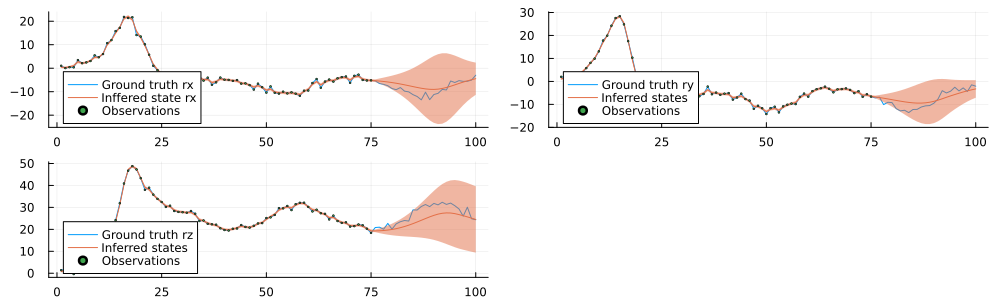

In [34]:
# Prediction visualization
rx, ry, rz = zeros(100), zeros(100), zeros(100)
rx_est_m, ry_est_m, rz_est_m = zeros(100), zeros(100), zeros(100)
rx_est_var, ry_est_var, rz_est_var = zeros(100), zeros(100), zeros(100)
for i=1:tt
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mean(x_est[i])[1], mean(x_est[i])[2], mean(x_est[i])[3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = var(x_est[i])[1], var(x_est[i])[2], var(x_est[i])[3]
end
for i=tt+1:100
    ii=i-tt
    rx[i], ry[i], rz[i] = testset[index][i][1], testset[index][i][2], testset[index][i][3]
    rx_est_m[i], ry_est_m[i], rz_est_m[i] = mo_list[ii][1], mo_list[ii][2], mo_list[ii][3]
    rx_est_var[i], ry_est_var[i], rz_est_var[i] = Vo_list[ii][1,1], Vo_list[ii][2,2], Vo_list[ii][3,3]
end
p1 = plot(rx,label="Ground truth rx")
p1 = plot!(rx_est_m,label="Inffered state rx",ribbon=rx_est_var)
p1 = scatter!(first.(testset[index][1:tt]), label="Observations", markersize=1.0)

p2 = plot(ry,label="Ground truth ry")
p2 = plot!(ry_est_m,label="Inferred states", ribbon=ry_est_var)
p2 = scatter!(getindex.(testset[index][1:tt], 2), label="Observations", markersize=1.0)

p3 = plot(rz,label="Ground truth rz")
p3 = plot!(rz_est_m,label="Inferred states", ribbon=rz_est_var)
p3 = scatter!(last.(testset[index][1:tt]), label="Observations", markersize=1.0)


plot(p1, p2, p3, size = (1000, 300),legend=:bottomleft)